In [1]:
"""
Purpose: To test the visualizations 
of just takig the average of node features

Psueodocode: 
1) Get the all batch data
2) Average across all of the batches
3) Plot with the given labels

"""

'\nPurpose: To test the visualizations \nof just takig the average of node features\n\nPsueodocode: \n1) Get the all batch data\n2) Average across all of the batches\n3) Plot with the given labels\n\n'

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import datajoint as dj
import trimesh
from tqdm.notebook import tqdm
from pathlib import Path

from os import sys
sys.path.append("/meshAfterParty/meshAfterParty")
sys.path.append("/python_tools/python_tools")
sys.path.append("/machine_learning_tools/machine_learning_tools/")
sys.path.append("/graph_tools/graph_tools/")
sys.path.append("/neuron_morphology_tools/neuron_morphology_tools/")
sys.path.append("/pytorch_tools/pytorch_tools/")

import datajoint_utils as du
from importlib import reload

WARNING - 2022-05-06 10:22:25,096 - _default - No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Using default Google credentials. There is no ~/.cloudvolume/secrets/google-secret.json set.


INFO - 2022-05-06 10:22:27,289 - settings - Setting enable_python_native_blobs to True
INFO - 2022-05-06 10:22:27,290 - settings - Setting stores to {'h01_skeletons': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/skeletons', 'stage': '/mnt/dj-stor01/microns/h01/skeletons'}, 'h01_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/meshes', 'stage': '/mnt/dj-stor01/microns/h01/meshes'}, 'h01_faces': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/faces', 'stage': '/mnt/dj-stor01/microns/h01/faces'}, 'h01_decimated_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/decimated_meshes', 'stage': '/mnt/dj-stor01/microns/h01/decimated_meshes'}, 'h01_soma_meshes': {'protocol': 'file', 'location': '/mnt/dj-stor01/microns/h01/soma_meshes', 'stage': '/mnt/dj-stor01/microns/h01/soma_meshes'}}
INFO - 2022-05-06 10:22:27,301 - connection - Connected celiib@at-database.ad.bcm.edu:3306


Connecting celiib@at-database.ad.bcm.edu:3306


INFO - 2022-05-06 10:22:28,393 - settings - Setting enable_python_native_blobs to True
WARNING - 2022-05-06 10:22:32,036 - utils - DataJointPlus version check failed.
INFO - 2022-05-06 10:22:33,644 - settings - Setting enable_python_native_blobs to True
ERROR - 2022-05-06 10:22:33,667 - compatibility - Could not add DataJointPlus to ImportMethod.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info_from_header
    if result[0] == attr:
IndexError: list index out of range
ERROR - 2022-05-06 10:22:33,721 - compatibility - Could not add DataJointPlus to Materialization.
Traceback (most recent call last):
  File "/datajoint-plus/datajoint_plus/compatibility.py", line 41, in add_datajoint_plus
    obj.parse_hash_info_from_header()
  File "/datajoint-plus/datajoint_plus/base.py", line 354, in parse_hash_info

In [4]:
from microns_morphology_api.schemas import minnie65_morphology as m65mor
m65mor.config.register_adapters(context=locals())
m65mor.config.register_externals()

from microns_morphology_api.schemas import minnie65_auto_proofreading as m65auto
m65auto.config.register_adapters(context=locals())
m65auto.config.register_externals()

In [5]:
from dataInterfaceMinnie65 import data_interface as hdju

In [6]:
import neuron_nx_utils as nxu
import networkx_utils as xu
import morphopy_utils as mpu

In [7]:
import dimensionality_reduction_ml as dru
import preprocessing_ml as preml
import pandas_ml as pdml
import pandas_utils as pu
import visualizations_ml as vml
import system_utils as su

In [8]:
#python_tools modules
import system_utils as su
import pandas_utils as pu
import pandas as pd
import numpy as np
import numpy_utils as nu
import networkx_utils as xu
from tqdm_utils import tqdm

#neuron_morphology_tools modules
import neuron_nx_io as nxio

# Loading the Data

In [11]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device = {device}")

device = cpu


In [12]:
with_skeleton = False

features_to_delete = [
    "mesh_volume",
    "apical_label",
    "basal_label",
]

if not with_skeleton:
    features_to_delete +=[
        "skeleton_vector_downstream_phi",      
        "skeleton_vector_downstream_theta",    
        "skeleton_vector_upstream_phi",        
        "skeleton_vector_upstream_theta",  
    ]

features_to_keep = None

In [13]:
import system_utils as su
data_path = Path("./data/m65_full/")
#list(data_path.iterdir())

gnn_task = "cell_type_fine"
label_name = None
graph_label = "cell_type_fine_label"
data_file = "df_cell_type_fine.pbz2"

data_filepath = Path(data_path) / Path(data_file)

data_df = su.decompress_pickle(data_filepath)
data_df

,segment_id,split_index,nucleus_id,external_layer,external_visual_area,cell_type_fine,cell_type_fine_label
0,864691134277239760,0,89719,LAYER_6,V1,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
1,864691134339067925,0,624899,LAYER_6,AL,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
2,864691134366116139,0,476756,WHITE_MATTER,RL,"[{'nodelist': ['L0_6'], 'features': ['mesh_vol...",NaN
3,864691134378215335,0,3799,LAYER_2/3,V1,"[{'nodelist': ['L0_1', 'L0_0', 'L0_2'], 'featu...",NaN
4,864691134527727930,0,631380,WHITE_MATTER,RL,"[{'nodelist': ['L0_0'], 'features': ['mesh_vol...",NaN
...,...,...,...,...,...,...,...
60448,864691137197334593,0,376218,LAYER_6,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_2', 'L0_5',...",NaN
60449,864691137197344065,0,191436,LAYER_2/3,V1,"[{'nodelist': ['L0_0', 'L0_1', 'L0_4', 'L0_6',...",NaN
60450,864691137197345345,0,584463,LAYER_2/3,RL,"[{'nodelist': ['L0_13', 'L4_5', 'L0_8', 'L2_5'...",NaN
60451,864691137197353281,0,591241,LAYER_5,RL,"[{'nodelist': ['L4_6', 'L1_10', 'L3_4', 'L0_10...",NaN


In [14]:
x_list = []
y_list = data_df[graph_label].to_list()
for gnn_info in data_df[gnn_task].to_list():
    x = nxio.feature_df_from_gnn_info(
        gnn_info[0],
        return_data_labels_split = False)
    x_list.append(x)

# This is where turn to max instead of mean!

In [15]:
df_mean_features = pd.concat([k.max() for k in x_list],axis=1).T
df_mean_features

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine
0,38.331768,0.0,0.0,0.0,0.0,0.0,4218.736339,0.000000e+00,1033.341211,895.524963,0.0,1.0,1.301845,1.421399,1.283103,1.385306,908.503296
1,29.928954,0.0,0.0,0.0,0.0,0.0,6767.224670,0.000000e+00,471.136497,869.454592,0.0,1.0,3.018812,2.002980,1.017846,2.069572,732.983276
2,5.177527,0.0,0.0,0.0,0.0,0.0,3206.663214,0.000000e+00,531.441932,366.946082,0.0,1.0,-0.809102,1.300793,-0.886743,1.278941,493.809220
3,12.129610,0.0,0.0,0.0,0.0,0.0,2453.172659,0.000000e+00,823.192239,835.479542,0.0,1.0,1.160867,1.566247,1.222258,1.581259,822.170199
4,24.522745,0.0,0.0,0.0,0.0,3.0,4493.930145,0.000000e+00,1590.580997,1427.002798,0.0,1.0,-2.036848,1.493445,-2.410269,1.731865,1448.651585
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,18749.290042,58.0,40.0,1.0,140.0,4.0,156625.815042,1.445362e+10,865.578971,895.905574,1.0,1.0,3.119619,3.050333,3.055038,2.998511,884.958137
60449,9531.954644,104.0,48.0,5.0,173.0,2.0,139359.458026,1.978160e+10,1024.923726,1024.923726,1.0,1.0,3.080753,2.764559,3.096107,2.736163,1024.923726
60450,12760.490066,118.0,72.0,7.0,227.0,3.0,182098.271727,3.231140e+10,1293.521298,1371.967455,1.0,1.0,3.094965,2.920173,3.072279,2.879682,1358.229518
60451,16130.660449,23.0,14.0,3.0,211.0,14.0,178799.474405,5.012415e+09,905.176688,905.176688,0.0,0.0,3.136321,3.098791,3.134145,2.892300,905.176688


In [16]:
label_name = "cell_type_fine_label"
df_mean_features[label_name] = y_list
df_mean_features

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
0,38.331768,0.0,0.0,0.0,0.0,0.0,4218.736339,0.000000e+00,1033.341211,895.524963,0.0,1.0,1.301845,1.421399,1.283103,1.385306,908.503296,NaN
1,29.928954,0.0,0.0,0.0,0.0,0.0,6767.224670,0.000000e+00,471.136497,869.454592,0.0,1.0,3.018812,2.002980,1.017846,2.069572,732.983276,NaN
2,5.177527,0.0,0.0,0.0,0.0,0.0,3206.663214,0.000000e+00,531.441932,366.946082,0.0,1.0,-0.809102,1.300793,-0.886743,1.278941,493.809220,NaN
3,12.129610,0.0,0.0,0.0,0.0,0.0,2453.172659,0.000000e+00,823.192239,835.479542,0.0,1.0,1.160867,1.566247,1.222258,1.581259,822.170199,NaN
4,24.522745,0.0,0.0,0.0,0.0,3.0,4493.930145,0.000000e+00,1590.580997,1427.002798,0.0,1.0,-2.036848,1.493445,-2.410269,1.731865,1448.651585,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60448,18749.290042,58.0,40.0,1.0,140.0,4.0,156625.815042,1.445362e+10,865.578971,895.905574,1.0,1.0,3.119619,3.050333,3.055038,2.998511,884.958137,NaN
60449,9531.954644,104.0,48.0,5.0,173.0,2.0,139359.458026,1.978160e+10,1024.923726,1024.923726,1.0,1.0,3.080753,2.764559,3.096107,2.736163,1024.923726,NaN
60450,12760.490066,118.0,72.0,7.0,227.0,3.0,182098.271727,3.231140e+10,1293.521298,1371.967455,1.0,1.0,3.094965,2.920173,3.072279,2.879682,1358.229518,NaN
60451,16130.660449,23.0,14.0,3.0,211.0,14.0,178799.474405,5.012415e+09,905.176688,905.176688,0.0,0.0,3.136321,3.098791,3.134145,2.892300,905.176688,NaN


In [17]:
import pandas_utils as pu
keep_idx = pu.find_all_rows_without_nan(df_mean_features)
df_no_nan = df_mean_features.iloc[keep_idx,:]
df_no_nan

,mesh_volume,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,apical_label,basal_label,skeleton_vector_downstream_phi,skeleton_vector_downstream_theta,skeleton_vector_upstream_phi,skeleton_vector_upstream_theta,width_no_spine,cell_type_fine_label
115,19665.721991,105.0,98.0,6.0,197.0,2.0,287543.113331,3.659868e+10,699.965529,710.729286,1.0,1.0,3.077228,2.971198,3.077228,2.976018,680.943803,4P
147,32311.880339,100.0,96.0,5.0,190.0,3.0,248923.783789,3.330438e+10,743.862767,847.734482,1.0,1.0,3.101901,2.982299,3.135811,2.907942,767.418252,23P
170,9298.981407,75.0,46.0,2.0,134.0,3.0,121035.955730,1.997734e+10,776.378367,827.272163,1.0,1.0,3.132823,2.803372,2.971502,3.021520,719.487746,5P_IT
205,36586.443370,118.0,74.0,4.0,251.0,5.0,289330.913935,2.364439e+10,924.869772,970.779759,1.0,1.0,3.128416,2.757216,3.084094,3.041478,926.251721,IT_short
213,2548.296837,60.0,48.0,3.0,128.0,1.0,94124.267809,1.657362e+10,1311.465019,711.032137,0.0,1.0,2.527475,2.647855,2.438781,2.742457,650.356959,23P
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60416,14600.041280,103.0,82.0,9.0,180.0,12.0,190192.997891,3.813632e+10,635.603087,645.127007,1.0,1.0,3.047003,2.894615,2.957533,2.894615,672.919087,4P
60417,8174.946772,36.0,25.0,4.0,341.0,4.0,166046.144275,5.756838e+09,830.680124,899.145754,0.0,0.0,3.115566,2.900826,2.877927,2.768284,864.429340,Unsure
60433,24553.232904,71.0,53.0,3.0,142.0,6.0,363677.211909,1.379262e+10,778.601828,752.698113,1.0,1.0,3.088132,2.824634,2.808953,2.850624,814.164512,5P_NP
60442,32910.785347,83.0,65.0,4.0,219.0,5.0,241913.631442,2.112465e+10,1019.561848,840.777841,1.0,1.0,3.134964,3.017149,3.041786,2.928137,827.090767,6P


In [18]:
target_name="cell_type_fine_label"

In [19]:
import preprocessing_ml as preml
df_scaled = preml.scale_df(df_no_nan,target_name=target_name)
data_cols = [k for k in df_scaled if k != label_name and k not in features_to_delete]
df_scaled = df_scaled[data_cols + [target_name]]
df_scaled

,n_spines,n_synapses_head,n_synapses_neck,n_synapses_post,n_synapses_pre,skeletal_length,total_spine_volume,width_upstream,width_downstream,width_no_spine,cell_type_fine_label
0,0.342881,1.190717,0.260027,0.060555,-0.622849,0.971186,1.103677,-0.471164,-0.427061,-0.426944,4P
1,0.225683,1.123639,-0.013005,-0.019146,-0.371176,0.488803,0.835712,-0.379073,-0.130277,-0.244190,23P
2,-0.360310,-0.553314,-0.832102,-0.656752,-0.371176,-1.108607,-0.248336,-0.310858,-0.174603,-0.345486,5P_IT
3,0.647597,0.385780,-0.286037,0.675390,0.132170,0.993517,0.049949,0.000661,0.136267,0.091486,IT_short
4,-0.711905,-0.486236,-0.559069,-0.725067,-0.874521,-1.444753,-0.525202,0.811696,-0.426405,-0.491586,23P
...,...,...,...,...,...,...,...,...,...,...,...
3333,0.296002,0.654092,1.079123,-0.133004,1.893879,-0.244786,1.228752,-0.606190,-0.569170,-0.443904,4P
3334,-1.274458,-1.257635,-0.286037,1.700114,-0.119503,-0.546398,-1.405061,-0.196939,-0.018909,-0.039168,Unsure
3335,-0.454069,-0.318541,-0.559069,-0.565665,0.383842,1.922155,-0.751414,-0.306194,-0.336147,-0.145397,5P_NP
3336,-0.172792,0.083928,-0.286037,0.311043,0.132170,0.401241,-0.155012,0.199314,-0.145347,-0.118079,6P


In [20]:
# -- mapping of the labels to integers --
total_labels,label_counts = np.unique((data_df.query(f"{graph_label}=={graph_label}")[
    graph_label]).to_numpy(),return_counts = True)
cell_type_map = {k:i+1 for i,k in enumerate(total_labels)}
cell_type_map[None] = 0
cell_type_map

{'1P': 1,
 '23P': 2,
 '4P': 3,
 '5P_IT': 4,
 '5P_NP': 5,
 '5P_PT': 6,
 '6CT': 7,
 '6P': 8,
 '6P_CT': 9,
 '6P_IT': 10,
 '6P_U': 11,
 'BC': 12,
 'BPC': 13,
 'I targeting non_bpc': 14,
 'IT_big_tuft': 15,
 'IT_short': 16,
 'IT_small_tuft': 17,
 'Martinotti': 18,
 'NGC': 19,
 'Pvalb': 20,
 'SST': 21,
 'Unsure': 22,
 'VIP': 23,
 'WM_P': 24,
 'cb1 basket': 25,
 'chandelier': 26,
 'l1vip': 27,
 'ndnf+npy_': 28,
 'ngfc': 29,
 'prox targeting': 30,
 'small basket': 31,
 None: 0}

In [21]:
#cell_type_map
cell_type_fine_classifier_weights = {
'23P': 0.25,#1294
'4P': 0.3,#890
'5P_IT': 0.5,#465
'6P': 0.8,#342
'6P_IT': 0.8,#263
'5P_PT': 0.8,#224
}


class_idx = np.array(list(cell_type_map.values()) )
class_labels = np.array(list(cell_type_map.keys()) )
weights = np.array([cell_type_fine_classifier_weights.get(k,1) for k in class_labels])
weights = weights[np.argsort(class_idx)]
weights

array([1.  , 1.  , 0.25, 0.3 , 0.5 , 1.  , 0.8 , 1.  , 0.8 , 1.  , 0.8 ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

# Creating the Custom Dataset

In [22]:
from torch.utils.data import Dataset, DataLoader
import torch

In [23]:
class MyDataset(Dataset):
    def __init__(self,):
        
        X,y = pdml.X_y(df_scaled,target_name="cell_type_fine_label")
        
        x=X.to_numpy().astype("float")
        y=y.to_numpy()
        
        y_int = [int(cell_type_map[k]) for k in y]

        self.x_train=torch.tensor(x,dtype=torch.float32)
        self.y_train=torch.tensor(y_int,dtype=torch.long)

    def __len__(self):
        return len(self.y_train)
  
    def __getitem__(self,idx):
        return self.x_train[idx],self.y_train[idx]
    
    @property
    def num_features(self):
        return self.x_train.shape[1]
    @property
    def num_classes(self):
        return np.max(np.unique(self.y_train)) + 1

In [24]:
dataset = MyDataset()

In [25]:
dataset_num_node_features = dataset.num_features
dataset_num_classes = dataset.num_classes

In [26]:
import preprocessing_utils as pret
batch_size = 64

(train_dataset,
val_dataset,
test_dataset,) = pret.train_val_test_split(
    dataset,
    return_dict=False,
    verbose = True)

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of val graphs: {len(val_dataset)}')

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)

test size = 667.0 (0.2 %)
validation size = 667.0 (0.2 %)
train_size = 2004.0
data_lengths_with_train = [2004  667  667]
Number of training graphs: 2004
Number of test graphs: 667
Number of val graphs: 667


In [27]:
dataset_num_node_features

10

# Picking the Model

In [36]:
n_epochs = 60

import evaluation_utils as evu
import torch.nn.functional as F
import model_utils as mdlu
verbose = True

In [37]:
import geometric_models as gm

model_name = "ClassifierFlat"

model = getattr(gm,model_name)(
    n_inputs=dataset_num_node_features,
    n_classes=dataset_num_classes,
    softmax=True
)

# Training the Model

In [38]:
optimizer_kwargs = dict(
    lr=0.01)

run_kwargs = optimizer_kwargs

In [39]:
optimizer = torch.optim.Adam(model.parameters(), **optimizer_kwargs)
print(model)



# ---------------- Configuring the Tensorboard and Checkpoinns--------------------
from torch.utils.tensorboard import SummaryWriter

tensorboard_dir = Path("./tensorboard")
tensorboard_dir.mkdir(exist_ok=True)
tensorboard_dir = tensorboard_dir / Path(f"{model_name}")
tensorboard_dir.mkdir(exist_ok=True)

tensorboard_file_name = (f'{model_name}_' 
                         + "_".join([f"{k}_{v}" for k,v in run_kwargs.items()]))
tensorboard_file_name += f"_with_skeleton_{with_skeleton}"
print(f"tensorboard_file_name = {tensorboard_file_name}")
tensorboard_file = tensorboard_dir / Path(f'{tensorboard_file_name}')
try:
    su.rm_dir(tensorboard_file)
except:
    pass
tensorboard_file.mkdir(exist_ok = True)


#-- when to save a checkpoint of the model
checkpoint_dir = Path("./model_checkpoints")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_dir = checkpoint_dir / Path(f"{model_name}")
checkpoint_dir.mkdir(exist_ok = True)
checkpoint_path = checkpoint_dir / Path(f"./{tensorboard_file_name}_checkpoints")

try:
    su.rm_dir(checkpoint_path)
except:
    pass

checkpoint_path.mkdir(exist_ok = True)
n_epoch_for_checkpoint = 5

writer = SummaryWriter(tensorboard_file)


print(model)


# weights = weight#[0.1,0.5,,1,0.7,1,1,1]
# class_weights = None
class_weights = torch.FloatTensor(weights).to(device)

tensor_map = None

def train():
    model.train()

    for data in train_loader:#train_loader:  # Iterate in batches over the training dataset.
        #print(f"data = {data}")
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)
        y_true = y.squeeze_()
        #print(f"out.shape = {out.shape}, data.y.shape = {data.y.shape}")
        loss = F.nll_loss(
            torch.log(out), y_true,
            weight = class_weights,
        )  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        return loss


def test(loader,verbose = False):
    model.eval()
    y_pred_list = []
    y_true_list = []
    for data in loader:  # Iterate in batches over the training/test dataset.
        X,y = data
        X = X.to(device)
        y = y.to(device)
        if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
        elif model_name == "TreeLSTM":
            n = data.x.shape[0]
            h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
            out = model(
                data,
                h = h,
                c = c,
                embeddings = data.x
                )
        else:
            out = model(X)

        y_pred = out.argmax(dim=1)  # Use the class with highest probability.
        y_true = y.squeeze_()
        y_pred_list.append(y_pred)
        y_true_list.append(y_true)
#         error_idx = np.where(pred > 0)[0]
#         if len(error_idx) > 0:
#             print(f"error_idx = {error_idx}")
    y_pred = torch.cat(y_pred_list)
    y_true = torch.cat(y_true_list)

    return evu.metric_dict(
        y_true,
        y_pred,
        tensor_map=tensor_map,
        metrics=["accuracy"],
    )

log_to_tensorboard = True
for epoch in range(0, n_epochs):
    loss = train()
    writer.add_scalar('loss',loss,epoch) # new line
    train_metric_dict = test(train_loader)#train_loader)
    val_metric_dict = test(val_loader)#test_loader)

    if epoch % n_epoch_for_checkpoint == 0 and epoch != 0:
        val_acc = val_metric_dict['accuracy'].numpy()
        checkpoitn_filepath = checkpoint_path / Path(f"{tensorboard_file_name}_epoch_{epoch}")#_val_acc_{val_acc:.2f}")
        print(f"Saving off checkpoint {checkpoitn_filepath}")
        mdlu.save_checkpoint(model,filepath = checkpoitn_filepath,epoch = epoch,loss = loss)


    print(f'Epoch: {epoch:03d}, loss = {loss}')
    for type_name,metric_dict in zip(["train","val"],[train_metric_dict,val_metric_dict]):
        print_log = f"   {type_name} metrics: "
        for k,v in metric_dict.items():
            if log_to_tensorboard:
                writer.add_scalar(f'{type_name}_{k}',v,epoch)
            print_log += f" {k}: {v:4f},"

        print(print_log)

    if val_metric_dict["accuracy"] < 0.0001:
        break

ClassifierFlat(
  (lin): Linear(in_features=10, out_features=32, bias=True)
)
tensorboard_file_name = ClassifierFlat_lr_0.01_with_skeleton_False
ClassifierFlat(
  (lin): Linear(in_features=10, out_features=32, bias=True)
)
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 1  2  4  6  8  9 10 12 13 15 16 18 19 20 21 22 23 24 25 27 28 31],y_pred_counts = [ 54  36  11 171  41 130   7 239   1 248  84  28  23  45 122  35  59   5
 124 314  14 213]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 1  2  4  5  6  8  9 10 12 13 15 16 18 19 20 21 22 23 24 25 27 28 31],y_pred_counts = [23  7  3  1 5

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 1  2  4  5  6  8  9 10 12 13 15 16 18 19 21 22 23 25 27 31],y_pred_counts = [ 12 178  14  84 323 144 164   1 529  10  57  66  72   1  25  12   2  11
 253  46]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 1  2  4  5  6  8  9 10 12 13 15 16 18 19 21 22 23 25 27 28 31],y_pred_counts = [  4  57   7  16 118  48  50   1 177   5  20  17  27   3  12   2   1   3
  90   1   8]
Epoch: 009, loss = 3.5406556129455566
   train metrics:  accuracy: 0.103792,
   val metrics:  accuracy: 0.110945,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 1

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 2  3  4  5  6  8  9 12 13 15 16 18 21 22 27],y_pred_counts = [321  63  40 107 415 311 234 402  28   3  20   8   6   1  45]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 15 16 18 21 27],y_pred_counts = [110  18  17  29 136 115  74   1 122  12   1   9   4   4  15]
Epoch: 019, loss = 3.0171732902526855
   train metrics:  accuracy: 0.208084,
   val metrics:  accuracy: 0.211394,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 2

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 2  3  4  5  6  8  9 12 13 18],y_pred_counts = [462 183  46 120 366 325 225 193  83   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 12 13],y_pred_counts = [156  55  21  35 113 116  73  62  36]
Epoch: 029, loss = 2.9481492042541504
   train metrics:  accuracy: 0.301896,
   val metrics:  accuracy: 0.305847,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12  

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [551 246  39 102 296 376 146   1 159  87   1]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13],y_pred_counts = [186  73  18  32  94 127  48   1  55  33]
Epoch: 039, loss = 2.816072702407837
   train metrics:  accuracy: 0.358283,
   val metrics:  accuracy: 0.364318,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7 

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [614 284  35 107 234 404  66  23 109 121   7]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [208  94  14  33  75 134  17   5  42  41   4]
Epoch: 049, loss = 2.580409049987793
   train metrics:  accuracy: 0.393214,
   val metrics:  accuracy: 0.398801,
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  4

   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 26 27 28 29],y_true_counts = [ 11 591 432 218  42  84  10 162  67 127  14  35  36   6  15  23  19  48
   7   3  22  12   3   8   1   1   5   2]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [647 315  21  95 189 377  48  73  86  90  63]
   y_true_unique= [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 27
 28 29 31],y_true_counts = [  1 202 148  71  17  30   8  55  19  30   1  18  12   2   7   3   7  11
   2   7   6   1   2   1   2   3   1]
   y_pred_unique= [ 2  3  4  5  6  8  9 10 12 13 18],y_pred_counts = [220 112  10  27  70 105  17  24  27  30  25]
Epoch: 059, loss = 2.637928009033203
   train metrics:  accuracy: 0.422156,
   val metrics:  accuracy: 0.431784,


# Testing the Data

In [40]:
all_data_loader = DataLoader(dataset, batch_size=batch_size,shuffle = False)
all_data_loader

In [41]:
model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

  0%|          | 0/53 [00:00<?, ?it/s]

In [42]:
np.unique(embedding_df["cell_type"].to_numpy(),return_counts=True)

(array(['1P', '23P', '4P', '5P_IT', '5P_NP', '5P_PT', '6CT', '6P', '6P_CT',
        '6P_IT', '6P_U', 'BC', 'BPC', 'I targeting non_bpc', 'IT_big_tuft',
        'IT_short', 'IT_small_tuft', 'Martinotti', 'NGC', 'Pvalb', 'SST',
        'Unsure', 'VIP', 'WM_P', 'cb1 basket', 'chandelier', 'l1vip',
        'ndnf+npy_', 'ngfc', 'prox targeting', 'small basket'],
       dtype=object),
 array([ 13, 984, 737, 365,  72, 142,  22, 254, 105, 198,  19,  71,  61,
         14,  29,  33,  32,  75,  11,   5,  36,  20,   7,  13,   2,   1,
          2,   7,   6,   1,   1]))

In [43]:
labeled_idx = embedding_df.query("cell_type != 'Unknown'").index.to_numpy()
labeled_mask_plotting = np.zeros(len(embedding_df))
labeled_mask_plotting[labeled_idx] = 1
labeled_mask_plotting = labeled_mask_plotting.astype("bool")
labeled_mask_plotting

array([ True,  True,  True, ...,  True,  True,  True])

# Step 6: Plotting Embeddings

In [44]:
%matplotlib inline
import visualizations_ml as vml
n_components = 3
import dimensionality_reduction_ml as dru

In [45]:
import pandas_ml as pdml
X_data,y_labels = pdml.X_y(embedding_df,"cell_type")

In [46]:
X = X_data[labeled_mask_plotting].to_numpy().astype("float")
y = y_labels[labeled_mask_plotting].to_numpy()

In [47]:
X_input=X[y!= "Unsure"]
y_input = y[y != "Unsure"]

# Prep) PCA Preprocessing

<Figure size 432x288 with 0 Axes>

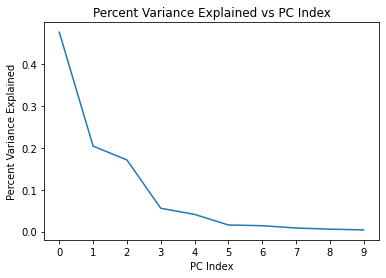

In [48]:
n_components_test=10
pca_data = dru.pca_analysis(
    X,
    n_components=n_components_test,
    plot_sqrt_eigvals=False,
    plot_perc_variance_explained=True
)

X_pca = pca_data["data_proj"]

# a) PCA

In [49]:
sys.path.append('/meshAfterParty/meshAfterParty/')
import datajoint_utils as du
import cell_type_utils as ctu

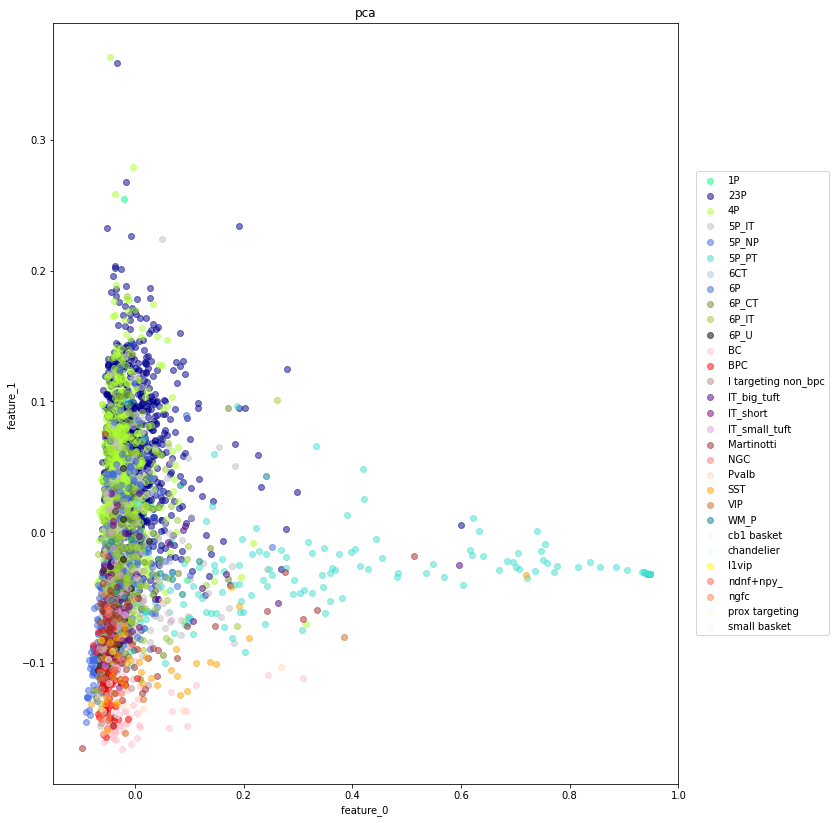

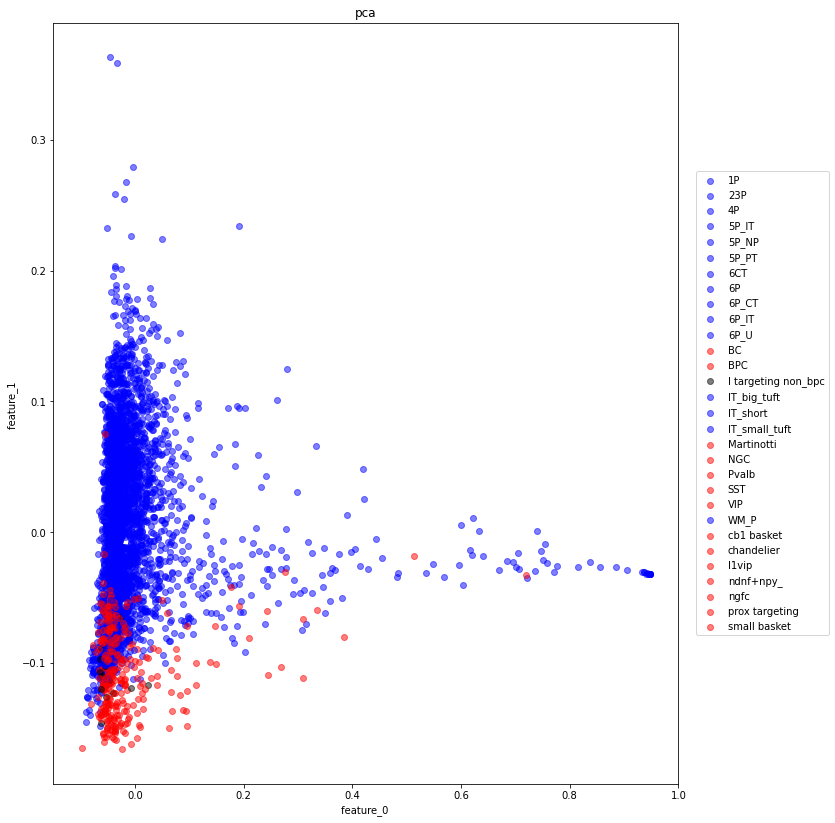

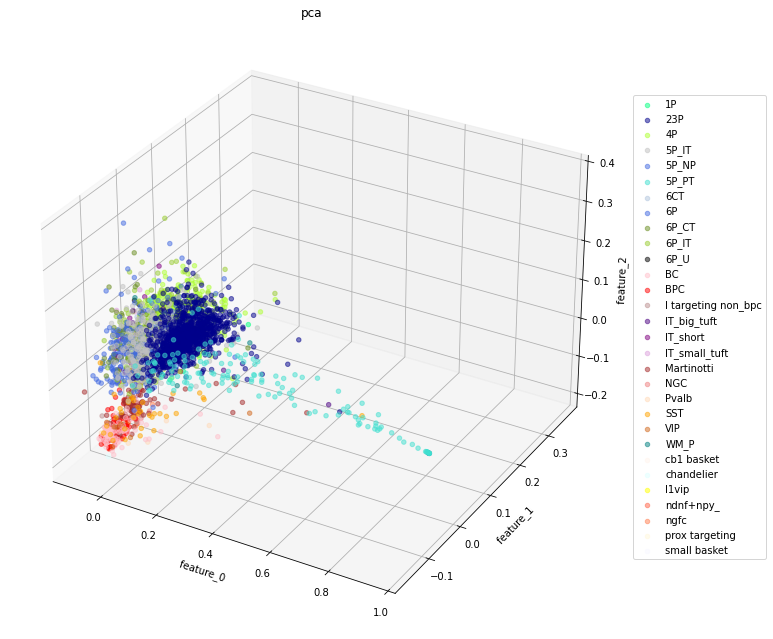

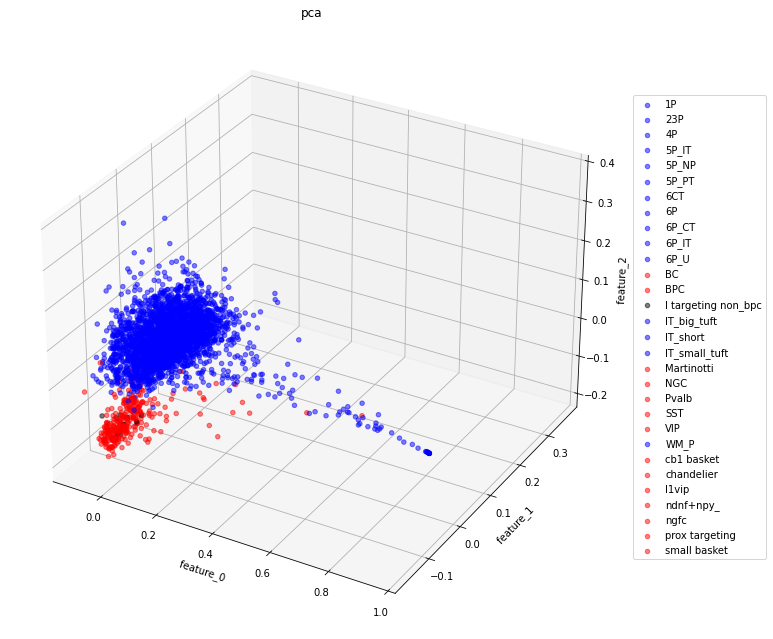

In [50]:
import dimensionality_reduction_ml as dru
import cell_type_utils as ctu
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "pca",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
)

# b) UMAP (0.5)

In [51]:
X_trans = dru.dimensionality_reduction_by_method(
        method="UMAP",
        X = X_input,
        n_components =2,
        min_dist = 0.5,
        )

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9100. The TBB threading layer is disabled.
  warnings.warn(problem)


In [52]:
method = "UMAP"

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

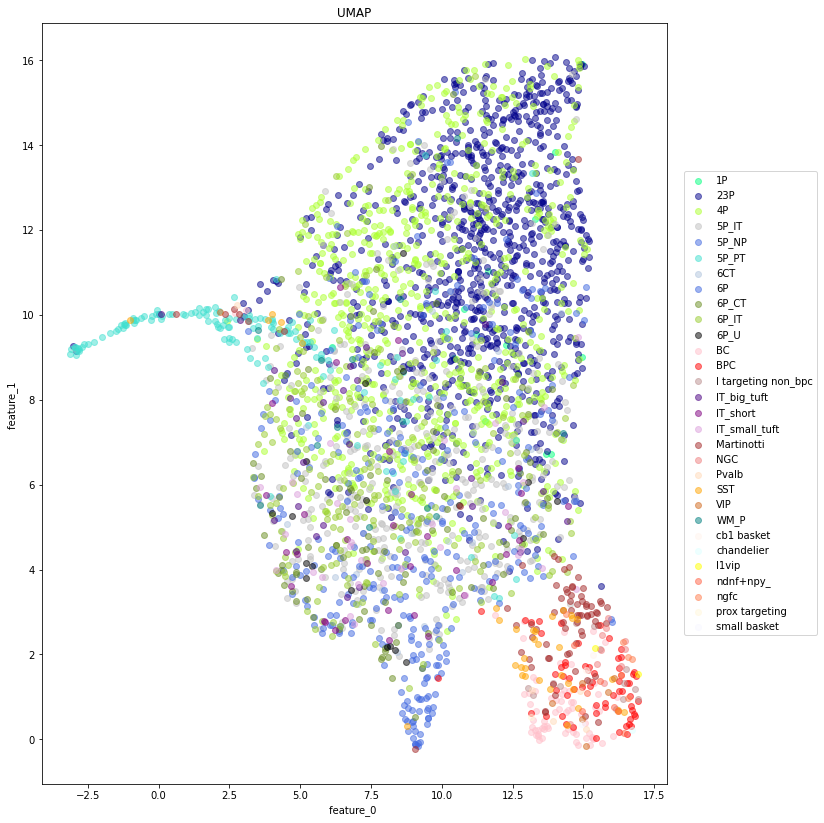

In [53]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

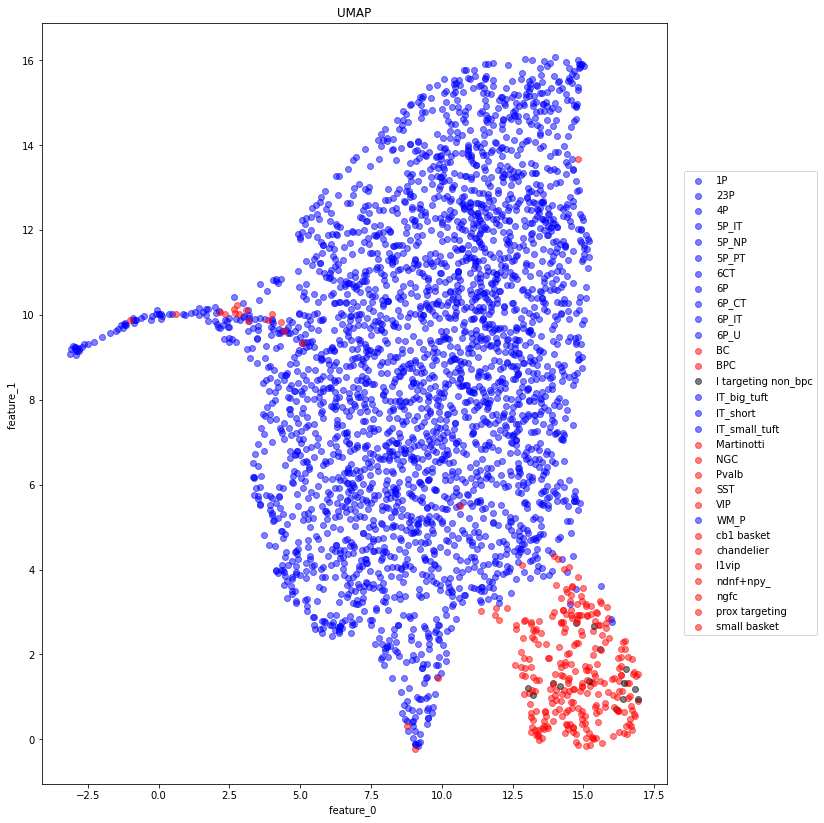

In [54]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.e_i_color_dict(),
                ndim = 2,
                title=method,
            )

<AxesSubplot:title={'center':'UMAP'}, xlabel='feature_0 ', ylabel='feature_1 '>

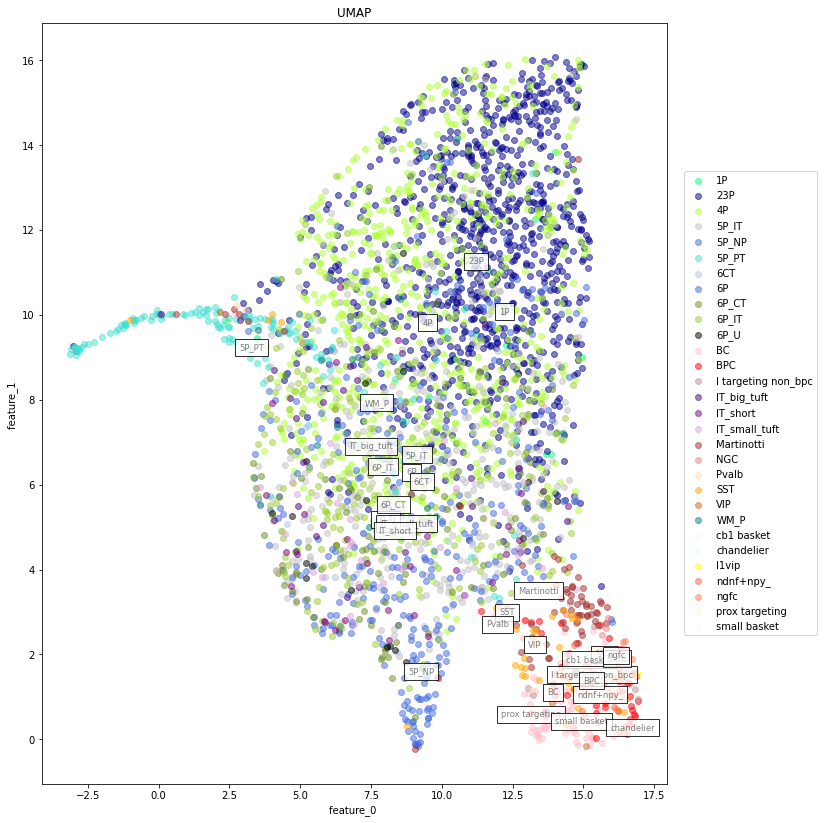

In [55]:
vml.plot_df_scatter_classification(
                X = X_trans,
                y = y_input,
                target_to_color = ctu.cell_type_fine_color_map,
                ndim = 2,
                title=method,
    use_labels_as_text_to_plot=True
            )

In [ ]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.5,
    #plot_kwargs=dict(use_labels_as_text_to_plot = True)
)

# b) UMAP (0.2)

In [ ]:
sys.path.append("/meshAfterParty/meshAfterParty/")
import datajoint_utils as du
import cell_type_utils as ctu

In [ ]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "umap",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    min_dist = 0.2,
)

# tsne

In [ ]:
vml.plot_dim_red_analysis(
    X=X_input,
    y=y_input,
    method = "tsne",
    color_mapppings = [
        ctu.cell_type_fine_color_map,
        ctu.e_i_color_dict()],
    #min_dist = 0.2,
)

# Running a Classification and then a confusion matrix

In [ ]:
embedding_df

In [ ]:
import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled

In [ ]:
accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
accuracy

In [ ]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["cell_type"],
    y_pred = df_labeled["cell_type_predicted"],
    labels = list(cell_type_map.keys()),
    figsize=(25,25),
    cell_fontsize = 14,
    ticklabel_fontsize=15)

# Confusion matrix of EI

In [ ]:
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]
df_labeled

In [ ]:
df_labeled_filt = df_labeled.query("e_i_label != 'unknown'")

In [ ]:
import statistics_visualizations as sviz
sviz.plot_pretty_confusion_matrix(
    y_true = df_labeled["e_i_label"],
    y_pred = df_labeled["e_i_predicted"],
    labels = list(df_labeled_filt["e_i_label"].unique()),
    figsize=(8,8),
    #cell_fontsize = 15,
    #ticklabel_fontsize=15
)

# Computing the Test Accuracy

In [56]:
all_data_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


cell_type_fine test accuracy: 0.42406015037593986
e_i_label test accuracy: 0.9458646616541353


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [57]:
all_data_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle = False)
all_data_loader

model.eval()
embeddings = []
labels = []
for data in tqdm(all_data_loader):#train_loader:  # Iterate in batches over the training dataset.
    
    X,y = data
    X = X.to(device)
    y = y.to(device)
    if model_name == "DiffPool":
            out,gnn_loss, cluster_loss = model(data)  # Perform a single forward pass.
            #y_true = data.y.reshape(-1,3)
    elif model_name == "TreeLSTM":
        n = data.x.shape[0]
        h = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        c = torch.zeros((n, architecture_kwargs["n_hidden_channels"]))
        out = model(
            data,
            h = h,
            c = c,
            embeddings = data.x
            )
    else:
        out = model(X)

    out_array = out.detach().cpu().numpy()
    out_labels = y.numpy().reshape(-1)
    #print(f"out_array.shape = {out_array.shape}, out_labels.shape = {out_labels.shape}")
    
#     if out_array.shape[0] != out_labels.shape[0]:
#         raise Exception("")
    
    embeddings.append(out_array)
    labels.append(out_labels)
    
    
    
embeddings = np.vstack(embeddings)
labels = np.hstack(labels)

embedding_df = pd.DataFrame(embeddings)
embedding_df["cell_type"] = labels

import general_utils as gu
decoder_map = dict([(v,k) if k is not None else (v,"Unknown") for k,v in cell_type_map.items()])

import pandas_utils as pu
embedding_df["cell_type"] = pu.new_column_from_dict_mapping(embedding_df,decoder_map,column_name = "cell_type")

import pandas_ml as pdml
df_labeled = embedding_df.query("(cell_type!='Unknown') and (cell_type != 'Unsure')")
X,y = pdml.X_y(df_labeled,"cell_type")
class_label_idx = np.argmax(X.to_numpy(),axis=1)
decoder = {v:k for k,v in cell_type_map.items()}
df_labeled["cell_type_predicted"] = [decoder[k] for k in class_label_idx]
df_labeled["e_i_label"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type"].to_numpy()]
df_labeled["e_i_predicted"] = [ctu.e_i_label_from_cell_type_fine(k) for k in df_labeled["cell_type_predicted"].to_numpy()]

accuracy = len(df_labeled.query("cell_type == cell_type_predicted"))/len(df_labeled)
print(f"cell_type_fine test accuracy: {accuracy}")
accuracy = len(df_labeled.query("e_i_label == e_i_predicted"))/len(df_labeled)
print(f"e_i_label test accuracy: {accuracy}")

  0%|          | 0/11 [00:00<?, ?it/s]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

cell_type_fine test accuracy: 0.4357034795763994
e_i_label test accuracy: 0.9455370650529501
